# AVISO

O conteúdo presente neste notebook é altamente baseado no quarto capítulo do livro <a ref='
https://www.amazon.com.br/dp/B08C2KM7NR/ref=dp-kindle-redirect?_encoding=UTF8&btkr=1' > 
Deep Learning for Coders with fastai and PyTorch: AI Applications Without a PhD</a>. Nosso objetivo é explicar em Portugês a implementação dos códigos e principais conceitos abordados pelo capítulo de modo que estudantes que falam português possam se iniciar no fastai e na aprendizagem de máquina prática. Se você deseja acessar o conteúdo original, você pode ler o seguinte <a href='https://course.fast.ai/start_gradient' > artigo  </a> a fim de aprender como executar o notebook contendo todos os capítulo disponibilizados de graça no <a href='https://gradient.run/notebooks'> Gradient </a>. Todos os créditos reservados aos autores Jeremy Howard and Sylvain Gugger. 


# 0- Configuração do notebook


Antes de qualquer coisa, iremos configurar nosso notebook como de costume:

In [1]:
import warnings
warnings.filterwarnings('ignore')

from fastbook import *

# 1- Introdução

Neste notebook, iremos nos aprofundar em conceitos de Deep Learning a fim de entender um pouco mais o que os modelos que treinamos até o momento estão realizando. 

Para tanto, iremos abordar um problema de visão computacional, a classificação de dígitos escritos a mão. Dessa forma, será empregado o dataset <a href='http://yann.lecun.com/exdb/mnist/'>MNIST</a>. Abaixo, segue breve descrição:

>O dataset MNIST contem imagens de dígitos escritos a mão coletadas pelo NIST (_National Institute of Standards and Technology_) e reunidas como um dataset de machine learning por Yann Lecun e seus colegas. Lecun usou o MNIST em 1998 no LeNet-5, o primeiro sistema computacional a demonstrar o reconhecimento de sequências de dígitos escritos a mão de forma prática e útil, o que é considerado um dos avanços mais importantes na história da IA. 

# 2- Como computadores lidam com imagens?

Para entender o que acontece em um modelo de visão computacional, precisamos entender primeiramente como computadores lidam com imagens. Para tanto, inicialmente iremos desenvolver um modelo simples que classifica imagens como dígitos 3 ou 7. 

Como visto nos notebooks passados, quando desejamos realizar o download de qualquer dataset, podemos empregar a função `untar_data`, a qual nos retorna o caminho de destino do dataset:

In [2]:
url_dataset = URLs.MNIST_SAMPLE
path = untar_data(url_dataset)

Se aplicarmos o método adicionado pelo fastai `.ls()`, poderemos verificar qual o conteúdo do diretório retornado.

Vale ressaltar que o método retorna um objeto de uma classe especial do fastai denominada `L`, a qual possui todas as funcionalidades do tipo built-in do Python `list`, bem como muitas outras. Por exemplo, exibir a quantidade de itens quando o objeto é impresso, além de listar alguns dos itens.

In [3]:
path.ls()

(#3) [Path('/home/lucaszampar/.fastai/data/mnist_sample/train'),Path('/home/lucaszampar/.fastai/data/mnist_sample/valid'),Path('/home/lucaszampar/.fastai/data/mnist_sample/labels.csv')]

Dessa forma, podemos perceber que há 3 itens no diretório retornado: a pasta `train`, que contém as imagens de treinamento; a pasta `valid`, imagens de validação; o arquivo `labels.csv`, os rótulos das imagens. Vale ressaltar que dividir as imagens de treinamento e de validação em pastas separadas é um padrão comum para datasets de machine learning.

Agora, vamos verificar o que há na pasta `train`:

In [4]:
(path/'train').ls()

(#2) [Path('/home/lucaszampar/.fastai/data/mnist_sample/train/7'),Path('/home/lucaszampar/.fastai/data/mnist_sample/train/3')]

Como esperado, há duas pastas referentes às classes de dígitos 3 e 7. Nesse caso, tais dígitos são as _labels_ do dataset. A partir disso, vamos referenciar os arquivos de imagem de cada pasta, ordenando-os conforme o nome. 

In [5]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('/home/lucaszampar/.fastai/data/mnist_sample/train/3/10.png'),Path('/home/lucaszampar/.fastai/data/mnist_sample/train/3/10000.png'),Path('/home/lucaszampar/.fastai/data/mnist_sample/train/3/10011.png'),Path('/home/lucaszampar/.fastai/data/mnist_sample/train/3/10031.png'),Path('/home/lucaszampar/.fastai/data/mnist_sample/train/3/10034.png'),Path('/home/lucaszampar/.fastai/data/mnist_sample/train/3/10042.png'),Path('/home/lucaszampar/.fastai/data/mnist_sample/train/3/10052.png'),Path('/home/lucaszampar/.fastai/data/mnist_sample/train/3/1007.png'),Path('/home/lucaszampar/.fastai/data/mnist_sample/train/3/10074.png'),Path('/home/lucaszampar/.fastai/data/mnist_sample/train/3/10091.png')...]

Como pode ser percebido pela saída, há 6.131 imagens do dígito 3 reservadas para o treinamento. Dessa forma, podemos exibir uma destas imagens ampliada:

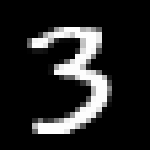

In [6]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3.resize((150, 150))

Para a exibição da imagem acima, empregamos a classe `Image` da biblioteca PIL (_Python 
Imaging Library_), que é o pacote do Python mais utilizado para abrir, manipular e ver imagens. 

Em um computador, tudo é representado por meio de números. Nesse contexto, para ver os números que compõem a imagem acima, podemos convertê-la para um __array NumPy__ ou um __tensor PyTorch__. Por exemplo, podemos verificar os números que compõem uma seção da imagem ao convertê-la para um array numpy:

In [7]:
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

Acima, acessamos as linhas de índice 4 até o 9 da matriz que configura a imagem, bem como a  coluna de índice 4 até o 9. Assim, estamos acessando uma região no canto superior esquerdo da imagem.

O mesmo procedimento pode ser realizado por meio de um tensor do Pytroch:

In [8]:
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

Além disso, podemos visualizar como os valores de pixels formam a imagem de um dígito ao transformar o array ou o tensor em um __dataframe Pandas__, aplicando um gradiente de cores em seguida.

In [9]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15, 4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


Você pode perceber que os valores de pixels brancos são armazenados como 0, os pretos como 255 e os tons de cinza estão entre os dois. A imagem contem ao todo 28 pixels de altura e 28 pixels de largura, ou seja, 768 pixels no total, o que é muito menor do que qualquer imagem que se pode tirar a partir da câmero de um smartphone.

# 3- Primeira tentativa: similaridade de pixel

Para solucionar o problema de classificar uma imagem como dígito 3 ou 7, inicialmente poderíamos, para cada classe de dígitos, encontrar o valor médio para cada pixel das imagens. A partir disso, tais valores constituíram os pixels de um dígito ideal. Dessa forma, a fim de classificar uma nova imagem, poderíamos identificar a similaridade com uma dessas imagens ideais. Essa abordagem certamente é melhor do que nada, o que será nossa __baseline__. 

> Baseline é um modelo ou solução simples para determinado problema cujos resultados serão comparados a implementações futuras mais complexas e sofisticadas. Dessa forma, serve como um referencial de que as abordagens seguintes estão realmente se tornando melhores. Nesse contexto, uma boa ideia para criar uma baseline é empregar um modelo simples e fácil de implementar, como o descrito acima. Outra ideia é procurar soluções já existentes e tomá-las como baseline.

A fim de implementar nossa ideia inicial, vamos criar dois tensores, cada um contendo todas as imagens de treinamento de cada dígito. Para criar um tensor contendo todas as imagens em um diretório, primeiramente vamos empregar a compreensão de listas do Python a fim de referenciar cada tensor individual das imagens.

In [10]:
three_tensors = [tensor(Image.open(_)) for _ in threes]
seven_tensors = [tensor(Image.open(_)) for _ in sevens]
print(f'Quantidade de imagens 3: {len(three_tensors)}') 
print(f'Quantidade de imagens 7: {len(seven_tensors)}')

Quantidade de imagens 3: 6131
Quantidade de imagens 7: 6265


Como pode ser visto pela saída, há 6.131 imagens para o digíto 3 no conjunto de treinamento; 6.265, para o dígito 7. A partir disso, podemos verificar uma das imagens de dígito 3 ao repassar um dos tensores para a função do fastai `show_image`

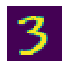

In [11]:
show_image(three_tensors[1]);

Agora, podemos combinar todas as imagens para cada lista em um tensor tridimensional (rank 3). Para tanto, nós empilhamos os tensores individuais de uma coleção em um único tensor por meio do método `stack`.

In [12]:
stacked_sevens = torch.stack(seven_tensors)
stacked_threes = torch.stack(three_tensors)

Vale ressaltar que algumas operações no PyTorch, como a média, requerem que o tipo de dado armazenado pelo tensor seja o `float`. Dessa forma, precisamos realizar o __casting__ do tensor. Além disso, será necessário dividir o tensor por 255 a fim de que os valores de intensidade os pixels estajam em um intervalo de 0 a 255 conforme o esperado.

In [13]:
stacked_sevens = stacked_sevens.float()/255
stacked_threes = stacked_threes.float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

Por meio do atributo `shape`, podemos verificar o comprimento de cada __eixo__ do tensor. Nesse caso, podemos concluir que temos 6.131 imagens do dígito 3, cada uma com 28 pixels de altura e de 28 pixels de largura respectivamente. Não há nada no tensor que indique que o primeio eixo é referente ao número de imagens, o segundo a altura e o terceiro a largura. A semântica de um tensor é responsabilidade nossa. 

O comprimento da forma de um tensor é seu rank ou dimensão:

In [14]:
len(stacked_threes)

6131

O rank, ou a dimensão, de um tensor pode ser verificado também pelo atributo `ndim`.

In [15]:
stacked_threes.ndim

3

Vale ressaltar aqui que há uma distinção entre a dimensão do tensor e o comprimentos de seus eixos. Imagine, por exemplo, que um tensor represente um vetor que guarda as coordenadas de um ponto em um espaço tridimensional. Apesar do vetor ter três componentes, o tensor que representa tal vetor tem apenas uma dimensão, pois um vetor é um tensor de rank 1. No caso, o comprimento do eixo deste tensor é 3. 

Finalmente, podemos computar o tensor referente ao dígito 3 ideal ao calcular a média dos valores de intensidade de pixel de todas imagens para cada posição de pixel. Para tanto, calculamos a média ao longo da dimensão 0 da pilha que representa o tensor de rank 3. Há outras dimensões possíveis que fazem referência às colunas e às linhas somente.

In [16]:
mean3 = stacked_threes.mean(0)

A partir disso, podemos exibir a imagem do dígito 3 ideal.

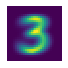

In [17]:
show_image(mean3)

Perceba que a imagem é intensa onde os pixels das 1imagens concordam, porém embaçada onde começam a distoar. Agora, vamos aplicar o mesmo procedimento para as imagens referentes ao dígito 7:

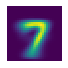

In [18]:
mean7 = stacked_sevens.mean(0)
show_image(mean7)

Com base nisso, a fim de determinar de qual dígito ideal uma nova imagem está mais próxima, devemos calcular a distância. Para tanto, podemos empregar __diferença média absoluta__ (também conhecida como __norma L1__) ou a __raíz quadrada do erro médio__ (também conhecido como __norma L2__). Nesse contexto, vamos definir duas funções para cada método:

In [19]:
def erro_medio_absoluto(tensor1, tensor2):
    return (tensor1 - tensor2).abs().mean()

def raiz_quadrada_erro_medio(tensor1, tensor2):
    return ((tensor1 - tensor2)**2).mean().sqrt()


Agora, vamos pegar alguma imagem do dígito 3.

In [20]:
im3 = stacked_threes[1]


Em segudida, iremos calcular as distâncias desta imagem em relação às imagens dos dígitos 3 e 7 ideais. 

In [21]:
mda_3 = erro_medio_absoluto(im3, mean3)
rmse_3 = raiz_quadrada_erro_medio(im3, mean7)

mda_3, rmse_3

(tensor(0.1114), tensor(0.3021))

In [22]:
mda_7 = erro_medio_absoluto(im3, mean7)
rmse_7 = raiz_quadrada_erro_medio(im3, mean7)

mda_7, rmse_7

(tensor(0.1586), tensor(0.3021))

Em ambos os casos, a distância entre nosso 3 e o 3 ideal é menor do que a distância em relação ao 7 ideal. Neste caso, nosso simples modelo nos dará a predição correta. O Pytorch já provê tais funções na forma de funções de custo (_loss functions_) por meio do módulo `torch.nn.functional` que pode ser acessado por meio de `F` pelo fastai.

In [23]:
F.l1_loss(im3.float(), mean7), F.mse_loss(im3, mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

# 4- Arrays NumPy e tensores PyTorch

<a href='https://numpy.org/'> NumPy </a> é uma das bibliotecas mais utilizadas para programação científica e numérica no Python. Porém, apesar de disponibilizar diversas funcionalidades semelhantes as dos tensores, não suporta utilizar a GPU para os cálculos, nem calcula gradientes.

Uma dúvida talvez posso surgir nesse momento: por que utilizar arrays e tensores? Porque eles são mais rápidos do que Python puro, que é uma linguagem lenta quando comparada a outras linguagens.

Um __array numpy__ é uma tabela de dados multidimensional com todos os itens do mesmo tipo. Nesse contexto, os itens podem ser outros arrays, sendo que os arrays mais internos podem ter tamanhos diferentes (_jagged array_). Se os itens são de tipos simples, como inteiros ou float, o NumPy irá armazená-los como uma estrutura de dados compacta do C na memória. Nesse contexto, NumPy possui uma grande variedade de operadores e métodos que podem executar computações nessas estruturas na mesma velocidade do C otimizado, porque elas são escritas em C.

Um tensor PyTorch é aproximadamente a memsa coisa que um array NumPy, porém com algumas restrições, por exemplo, não adimitir _jagged array_, e funcionalidade adicionais. Nesse contexto, tais estruturas podem habitar a GPU, o que acelara as computações, além de calcular automaticamente de gradientes. 

Agora, vamos criar um array e um tensor:

In [24]:
data = [[1,2,3],[4,5,6]]
arr = array(data)
tns = tensor(data)

In [25]:
arr

array([[1, 2, 3],
       [4, 5, 6]])

In [26]:
tns

tensor([[1, 2, 3],
        [4, 5, 6]])

Nesse caso, as estruturas representam uma matriz. Podemos acessar o primeiro elemento, isto é, a primeira linha por meio de:

In [27]:
tns[0]

tensor([1, 2, 3])

Além de empregar _slicing_ para percorrers tanto linhas como colunas. Abaixo, selecionamos todas as linhas da segnda coluna.

In [28]:
tns[:, 1]

tensor([2, 5])

Já no seguinte exemplo escolhemos apenas a segunda linha das segunda e terceiras colunas

In [29]:
tns[1, 1:3]

tensor([5, 6])

Além disso, é possível aplicar operações aritiméticas a todos os itens do tensor diretamente.

In [30]:
tns+1


tensor([[2, 3, 4],
        [5, 6, 7]])

Vale ressaltar que os tensores possuem um tipo.

In [31]:
tns.type()

'torch.LongTensor'

O qual será alterado automaticamente de acordo com o contexto da operação. 

In [32]:
tns = tns*1.5
tns

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

In [33]:
tns.type()

'torch.FloatTensor'

# 5- Computando métricas por meio de _brodcasting_

Lembre-se que uma métrica é um número calculado com base nas predições do nosso modelo e as _labels_ corretas no nosso dataset de modo a nos dizer quão bom nosso modelo é. Apesar de podermos utilizar as funções que vimos anteriormente, como o erro médio absoluto, geralmente utilizamos a acurácia como métrica de modelos de classificação pode ser mais amigável.

No exemplo da nossa _baseline_, não correremos o risco de superadpatar nosso modelo aos dados (_overffiting_), já que não há componentes treináveis. Porém, a fim de seguir as convenções, empregaremos o conjunto de validação já definido. Dessa forma, vamos criar os tensores referentes às imagens dos dígitos 3 e 7 no conjunto de validação.

In [34]:
valid_3_tns = torch.stack( [ tensor(Image.open(_)) for _ in (path/'valid'/'3').ls()] )
valid_3_tns = valid_3_tns.float()/255

valid_7_tns = torch.stack( [ tensor(Image.open(_)) for _ in (path/'valid'/'7').ls()] )
valid_7_tns = valid_7_tns.float()/255

valid_3_tns.shape, valid_7_tns.shape


(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

Podemos perceber pela saída acima que há 1010 imagens do 3 para validação, enquanto que há 1028 do 7. Agora, vamos começar a implementar uma forma de classificar tais imagens. Inicialmente, precisamos escrever uma função que verifica a distância entre dada imagem e a imagem ideal dos dígitos 3 e 7. Nesse caso, empregaremos o erro médio absoluto.

In [35]:
def mnist_distance(a,b): 
    return (a-b).abs().mean((-1,-2))

Algo interessante pode ocorrer aqui. As operações aplicadas entre tensores não exigem que eles tenham necessariamenta a mesma dimensão. Por exemplo, se passarmos um tensor de rank 3 contendo todas as imagens de validação de um dos dígitos e outro de rank 2 representando apenas uma imagem do dígito ideal, o resultado será um tensor contendo o resultado da operação aplicada item a item do tensor maior em relação ao menor. Dessa forma, podemos aplicar o cálcula da distância para todos os itens do conjunto de validação de uma só vez.

In [36]:
valid_3_dist = mnist_distance(valid_3_tns, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1512, 0.1200, 0.1621,  ..., 0.1603, 0.1364, 0.1541]),
 torch.Size([1010]))

Podemos perceber pela saída acima que é retornado um tensor de rank 1 com 1010 itens, cada um sendo o resultado do cálculo de distância entre o a imagem daquela posição com a imagem do dígito ideal 3. Para tanto, o PyTorch aplica o __broadcasting__, isto é, ele expande o tensor de menor rank para ter o mesmo tamanho do de maior. Após o broadcasting, os tensores possuem o mesmo rank, então o Pytorch aplica a mesma lógica que empregaria para tensores de mesmo rank no cálculo aritimético. 

In [37]:
tensor([1,1,1], [1,1,1]) + tensor([1,1,1])

tensor([[2, 2, 2],
        [2, 2, 2]])

Pense como se o Pytorch fizesse 1010 cópias da imagem do 3 ideal, calculando a distância entre ela e as demais imagens de validaçãoem seguida. No início, ele simplesmente subtrai os valores de intensidade de pixel entre as imagens. Nesse momento, teríamos como resutlado um tensor de rank 3.

In [38]:
(valid_3_tns - mean3).shape

torch.Size([1010, 28, 28])

Vale ressaltar que o Pytorch não cria de fato 1010 cópias da imagem, o que demandaria a alocação de memória adicional desnecessária. Além disso, todos os cálculos são feitos em C, ou em CUDA quando utiliza a GPU, o que é dezena de milhares de vezes mais rápido do que Python puro.

Em seguida, é aplicado o método `abs` para o cálculo do valor absoluto. Nesse sentido, valores de pixels resultantes negativos 

In [39]:
((valid_3_tns-mean3).abs()).shape

torch.Size([1010, 28, 28])

Por fim, calcumos a média. Nesse caso, a tupla (-1,-2) indica ao longo de quais eixos se deseja calcular a média. Nesse sentido, -1 indica o eixo horizontal (linhas); -2, eixo vertical (colunas). Assim, a tupla indica que desejamos calcular a média para esses dois eixos. No final, teremos o tensor de rank 1 com 1010 itens.


In [40]:
((valid_3_tns-mean3).abs().mean((-1,-2))).shape

torch.Size([1010])

A partir disso, podemos definir uma função que avalia se a imagem em questão se refere ao dígito 3. Para tanto, basta avaliar se a distância entre a a imagem dada e a do 3 ideal é menor do que a do 7 ideal. Chamaremos essa função de `is_3`.

In [41]:
def is_3(x): return mnist_distance(x, mean3) < mnist_distance(x, mean7)

O mesmo pode ser feito para o 7:

In [42]:
def is_7(x): return mnist_distance(x, mean7) < mnist_distance(x, mean3)

A partir disso podemso aplicar para os dos conjuntos de validação

In [43]:
valid_3s = is_3(valid_3_tns)
valid_7s = is_7(valid_7_tns)
valid_3s


tensor([False,  True,  True,  ..., False,  True,  True])

Podemos perceber que nos é retornado um tensor de booleanos. A fim de calculcar a acurácia, isto é, a média dos acertos. Podemos converter o tipo do tensor para o float. 

In [44]:
accuracy_3s =  valid_3s.float().mean()
accuracy_7s =  valid_7s.float().mean()
accuracy_3s, accuracy_7s, (accuracy_3s+accuracy_7s)/2 

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

Percebemos que a acurácia média da nossa baseline é muito boa, sendo maior do que 90%. Porém, sejamos honestos. Os dígitos 3 e 7 são muito diferentes. Além disso, estamos classificando apenas duas dentre dez possibilidades. Para fazermos melhor que isso, devemos acrescentar um pouco mais de aprendizagem.

# 6- Gradiente estocástico descendente

Atualmente, não somos capazes melhorar nossa abordagem de similaridade de pixel ao ajusta um conjunto de parâmetros. Para ter as vantagens do poder do deep learning, nós primeiro temos que representar nossa tarefa na forma como Arthur Samuel descreveu, isto é, atrubuir pesos ao modelo, bem como testar a eficácia da atribuição atual de pesos. 

Em vez tentar encontrar a similaridade entre uma imagem e uma imagem iseal, poderíamos olhar para cada pixel individual e atribuir um peso. Assim, pesos maiores poderiam estar associados com pixels mais prováveis de serem intensos para uma determinada categoria. Por exemplo, pixels na metade direita da imagem não são muito prováveis de serem ativados para um 7, possuindo, pois, valores de peso baixos. No entanto, o mesmo não ocorre provavelmente para um 8. Dessa forma, poderíamos implementar uma função que recebe como parâmetros a imagem representada por um longo vetor de pixels, bem como o vetor de pesos para cada pixel, de modo a reconhecer o dígito 8.

In [45]:
def pr_eight(x, w): (x*w).sum()

Agora, precisamos de um modo para atualizar os pesos a fim de torná-los melhores. Dessa forma, podemos repetir esse passo quantas vezes quisermos, tornando os pesos melhores e melhores até serem tão bons quanto quisermos de sorte que a função retorne valores altos para imagens do dígito 8; menores, para aquelas diferentes. Pra tanto, podemos empregar os seguintes passos:

<blockquote>

<ol>
    <li>Inicializar os pesos</li>
    <li>Para cada imagem, utilize os pesos para predizer se a imagem se parece com o dígito em questão.</li>
    <li> Com base nas predições, calcular quão o modelo é, isto é, sua loss </li>
    <li> Calcular o gradiente, que mede como a mudança de cada peso mudaria a loss </li>
    <li> Mude todos os pesos a partir desse cálculo (step) </li>
    <li> Volte para o segundo passo e repita o processo </li>
    <li> Itere até decidir parar o processo de treinamento </li>
</ol>

</blockquote>

Os sete passos descritos acima sào a chave para o treinamento de todos os modelos de deep learning. Há diversas formas de realizar cada passo, esses são os detalhes que fazem muita diferença para os praticantes de deep learning. Porém, podemos definir alguns princípios básicos para determinados passos:

<blockquote>
<dl>
<dt> Inicialização: </dt>
<dd>Inicialize os parâmetros com valores aleatórios </dd>

<dt> Loss: </dt>
<dd> Aplique uma função para avaliar a performance atual do modelo (loss). Por convenção, essa função deve retorar um valor alto, se a performance for ruim; baixo, de for boa </dd>

<dt> Step: </dt>
<dd> Calcule o gradiente, o qual, por meio de conceitos do Cálculo, descobre em qual direção e por quanto se deve mudar o valor de cada peso. Em seguida, atualize os valores dos pesos. </dd>

<dt> Parada: </dt>
<dd> Adore um critério de parada, por exemplo, o momento a partir do qual a acurácia fica cada vez pior ou um número fixo de épocas ou um limite de tempo de execução. </dd>

</dl>

</blockquote>

Antes de aplicarnos esses passos para nosso problema de classificação de imagem, vamos ilustrá-los em um simples caso. Para tanto, vamos considerar que nossa função de custo seja muito simples como quadrática. Assim, a função f(x)= x<sup>2</sup> será nossa função de custo; x, nosso parâmetro.  

In [46]:
def f(x): return x**2

Abaixo, podemos ver o gráfico da função.

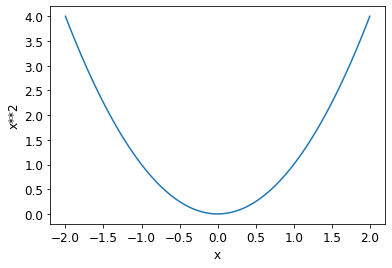

In [47]:
plot_function(f, 'x', 'x**2')

A partir disso, iniciamos nosso parâmetro com um valor aleatório. Nesse caso, vamos supor que o valor escolhido seja -1.5. Com isso, nossa função retornará 2.25.

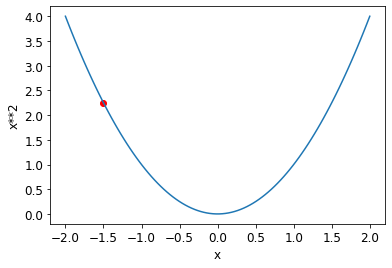

In [48]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

Agora, precisamos saber em qual direção seguir de modo a reduzir o valor da função. Para tanto, podemos analisar a inclinação da reta (laranja) tangente ao gráfico no ponto inicial, ou seja, a derivada neste ponto. Então, percebemos que devemos ajustar o valor do parâmetro na direção da seta vermelha para reduzirmos o valor da função.

[(0, 4), Text(0, 0.5, 'x**2'), (-2.5, 2.5), Text(0.5, 0, 'x')]

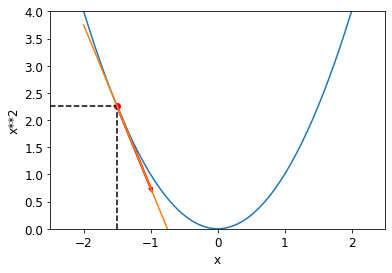

In [49]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

x = np.linspace(-2.0, 2.0)
y = f(x)

x0 = -1.5

#CURVAS
ax.plot(x, y)
ax.plot(x, -3*(x)-2.25)
#PONTO
ax.scatter(x0, f(x0), color='red')
#LINHAS TRACEJADAS
plt.vlines(x0, 0, f(x0), linestyle="dashed")
plt.hlines(f(x0), -2.5, x0, linestyle="dashed")
#FLECHA
ax.arrow(x0, f(x0),  abs(x0 - (-1)), -(f(x0)-(-3*(-1) -2.25)), width=.02, color='red')
#CONFIG
ax.set(xlabel='x', ylabel='x**2', ylim=(0,4), xlim=(-2.5, 2.5))


Podemos repetir esse procedimento novamente, calculando o valor da loss para o novo valor de parâmetro e ajustando-o em seguida, até chegar no menor ponto da nossa curva.

[(0, 4), Text(0, 0.5, 'x**2'), (-2.5, 2.5), Text(0.5, 0, 'x')]

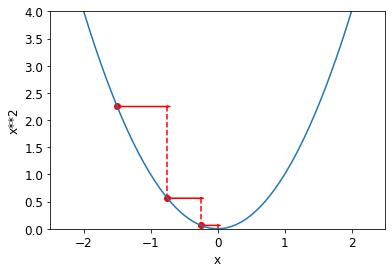

In [50]:
import numpy as np
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

x = np.linspace(-2.0, 2.0)
y = f(x)

x0 = -1.5
x1 = -0.75
x2 = -0.25

#CURVAS
ax.plot(x, y)

#PONTOS
ax.scatter(x0, f(x0), color='red')
ax.scatter(x1, f(x1), color='red')
ax.scatter(x2, f(x2), color='red')

#LINHAS
plt.vlines(x1, f(x0), f(x1), linestyle="dashed", color='red')
plt.vlines(x2, f(x1), f(x2), linestyle="dashed", color='red')
plt.vlines(0, f(x2), 0, linestyle="dashed", color='red')
#FLECHAS
ax.arrow(x0, f(x0),  abs(x0 - (x1)), 0, width=.01, color='red')
ax.arrow(x1, f(x1),  abs(x1 - (x2)), 0, width=.01, color='red')
ax.arrow(x2, f(x2),  abs(x2 - 0), 0, width=.01, color='red')

#CONFIG
ax.set(xlabel='x', ylabel='x**2', ylim=(0,4), xlim=(-2.5, 2.5))



Por meio desse método, conseguimos otimizar qualquer função arbitrária. Não importa quão complicada seja nossa função, a abordagem básica do gradiente descendente não mudará tanto. As menores mudanças estarão em como torná-lo mais rápido ao encontrar passos melhores.

## 6.1 - Calculando gradientes

Como visto anteriormente, o gradiente diz quanto devemos mudar cada parâmetro do modelo de modo a torná-lo melhor. Para tanto, é empregado a derivada da função de custo, que nos informa a variação da função em determinado ponto. Quando nós sabemos como nossa função varia, sabemos o que é necessário para torná-la menor. Isso é o ponto chave para o machine learning: ter uma método para mudar parâmetros de uma função a fim de torná-la menor. Nesse contexto, o PyTorch possui a funcionalidade muito interessante de calcular gradientes automaticamente.

In [51]:
xt = tensor(3.).requires_grad_()

Por meio do método `requires_grad_()`, especificamos que desejamos calcular gradientes futuros em relação ao valor da variável especificado, nesse caso, 3. A partir disso, podemos calcular o valor da nossa função no ponto desejado.

In [52]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

Perceba que ao imprimirmos, além da imagem da função no ponto 3, é informado também qual função será empregada para o cálculo do gradiente. Com base nisso, podemos calcular o gradiente para função no ponto repassado.

In [53]:
yt.backward()

O método `backward` se refere a __backpropagation__, que é o nome do processo de calcular a derivadada para cada camada do modelo. Essa etapa geralmente é chamada __backward pass__, em oposição ao __forward pass__, quando as ativações são calculadas. Agora, podemos verificar o valor do gradiente para o ponto dado.

In [54]:
xt.grad

tensor(6.)

O valor 6 se deve ao fato de que a derivada da função no ponto dado é 6. Lembre-se que a derivada de f(x) = x<sup>2</sup> é f<sup>'</sup>(x) = 2x. Nesse sentindo, para o ponto dado, f<sup>'</sup>(3) = 6. Agora, iremos repetir o processo, porém com um vetor como argumento para nossa função.

In [55]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

Além disso, iremos acrescentar o método `sum` a nossa função original de sorte que ela possa receber um tensor de rank 1 e retornar um escalar, isto é, um tensor de rank 0, que representaria a loss do modelo para os parâmetros repassados no vetor.

In [56]:
def f(x): return (x**2).sum()


In [57]:
yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

Agora, podemos calcular o gradiente para cada ponto especificado.

In [58]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

Percebemos que para os pontos dados, os valores do gradiente são 6, 8 e 20 respectivamente, ou seja, o valor da derivida da função nesses pontos.

Vale ressaltar que os valores do gradiente apenas nos indicam a inclinação da função nos pontos especificados. Eles não expressam exatamente quanto ajustar os parâmetros. Porém, temos alguma ideia a partir deles. Se a inclinação é muito grande, significa que temos mais ajustes para fazer, enquanto que se for muito pequena, possivelmente estamos perto de um valor ótimo.

## 6.2 - Stepping com a taxa de aprendizagem

Decidir como mudar nossos parâmetros baseando-se nos valores do gradiente é uma importante parte do processo de deep learning. Quase todas as abordagens partem da mesma ideia básica de multiplicar o gradiente por um valor pequeno, denominado taxa de aprendizagem ou _learning rate_ do inglês.  Gearalmente, seleciona-se um valor entre 0.001 e 0.1, embora possa ser qualquer valor. A partir do momento que a taxa de aprendizagem for escolhida, podemos aplicar a seguinte função para atualizar nossos parâmetros:

In [59]:
def update(w, lr): return w - w.grad * lr

Aqui, algumas considerações sobre o valor escolhido para a taxa de aprendizagem devem ser feitas. Por exemplo, caso seja muito pequeno, talvez muitos _steps_ sejam necessários, como ilutra o gráfico abaixo.

[(0, 4), Text(0, 0.5, 'x**2'), (-2.5, 2.5), Text(0.5, 0, 'x')]

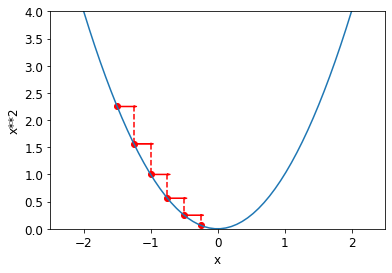

In [60]:
import numpy as np
import matplotlib.pyplot as plt

def quad(x): return x**2

fig, ax = plt.subplots()

x = np.linspace(-2.0, 2.0)
y = x**2

x0 = -1.5
x1 = -1.25
x2 = -1.0
x3 = -0.75
x4 = -0.5
x5 = -0.25

#CURVAS
ax.plot(x, y)

#PONTOS
ax.scatter(x0, quad(x0), color='red')
ax.scatter(x1, quad(x1), color='red')
ax.scatter(x2, quad(x2), color='red')
ax.scatter(x3, quad(x3), color='red')
ax.scatter(x4, quad(x4), color='red')
ax.scatter(x5, quad(x5), color='red')


#LINHAS
plt.vlines(x1, quad(x0), quad(x1), linestyle="dashed", color='red')
plt.vlines(x2, quad(x1), quad(x2), linestyle="dashed", color='red')
plt.vlines(x3, quad(x2), quad(x3), linestyle="dashed", color='red')
plt.vlines(x4, quad(x3), quad(x4), linestyle="dashed", color='red')
plt.vlines(x5, quad(x4), quad(x5), linestyle="dashed", color='red')

#FLECHAS
ax.arrow(x0, quad(x0),  abs(x0 - x1), 0, width=.01, color='red')
ax.arrow(x1, quad(x1),  abs(x1 - x2), 0, width=.01, color='red')
ax.arrow(x2, quad(x2),  abs(x2 - x3), 0, width=.01, color='red')
ax.arrow(x3, quad(x3),  abs(x3 - x4), 0, width=.01, color='red')
ax.arrow(x4, quad(x4),  abs(x4 - x5), 0, width=.01, color='red')

#CONFIG
ax.set(xlabel='x', ylabel='x**2', ylim=(0,4), xlim=(-2.5, 2.5))


Porém, se for muito alto, o resultado pode ser ainda pior, com o valor da loss se tornando cada vez maior, como é ilustrado no gráfico abaixo.

[(0, 4), Text(0, 0.5, 'x**2'), (-2.5, 2.5), Text(0.5, 0, 'x')]

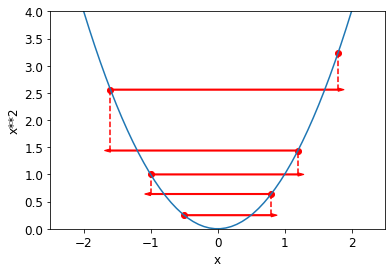

In [61]:
import numpy as np
import matplotlib.pyplot as plt

def quad(x): return x**2

fig, ax = plt.subplots()

x = np.linspace(-2.0, 2.0)
y = x**2

x0 = -0.5
x1 = 0.8
x2 = -1.0
x3 = 1.2
x4 = -1.6
x5 = 1.8

#CURVAS
ax.plot(x, y)

#PONTOS
ax.scatter(x0, quad(x0), color='red')
ax.scatter(x1, quad(x1), color='red')
ax.scatter(x2, quad(x2), color='red')
ax.scatter(x3, quad(x3), color='red')
ax.scatter(x4, quad(x4), color='red')
ax.scatter(x5, quad(x5), color='red')


#LINHAS
plt.vlines(x1, quad(x0), quad(x1), linestyle="dashed", color='red')
plt.vlines(x2, quad(x1), quad(x2), linestyle="dashed", color='red')
plt.vlines(x3, quad(x2), quad(x3), linestyle="dashed", color='red')
plt.vlines(x4, quad(x3), quad(x4), linestyle="dashed", color='red')
plt.vlines(x5, quad(x4), quad(x5), linestyle="dashed", color='red')

#FLECHAS
ax.arrow(x0, quad(x0),  abs(x0 - x1), 0, width=.02, color='red')
ax.arrow(x1, quad(x1),  -abs(x1 - x2), 0, width=.02, color='red')
ax.arrow(x2, quad(x2),  abs(x2 - x3), 0, width=.02, color='red')
ax.arrow(x3, quad(x3),  -abs(x3 - x4), 0, width=.02, color='red')
ax.arrow(x4, quad(x4),  abs(x4 - x5), 0, width=.02, color='red')


#CONFIG
ax.set(xlabel='x', ylabel='x**2', ylim=(0,4), xlim=(-2.5, 2.5))

Além disso, em vez de divergir, ela pode oscilar. Como resultado, o treinamento exige mais _steps_.

## 6.3 - Um exemplo fim-a-fim do gradiente descendente

Imagine que você está medindo a velocidade de um carrinho a partir de uma das colinas de uma montanha russa. Ele começaria rápido ao descer a colina, então ficaria mais lento a medida que sobe novamente até chegar ao topo com velocidade mínima, acelerando em seguida ao descer. Nesse contexto, você quer criar um modelo de como a velocidade varia com o passar do tempo. Se você estivesse medindo a velocidade manualmente a cada segundo durante 20 segundos, você poderia acabar encontrando um resultado como o seguinte:

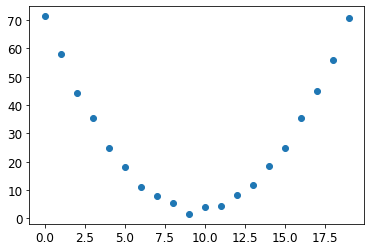

In [62]:
time = torch.arange(0, 20).float()
speed = torch.rand(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time, speed)

Acrescentamos um pouco de ruído aleatório, já que medir coisas manualmente não é preciso. Isso significa que não é tão fácil responder a questão: qual foi a velocidade do carrinho na montanha russa? Utilizando o SGD, nós podemos tentar encontrtar uma função que se encaixe com nossas observações. Porém, nós não conseguimos considerar todas as funções possíveis. Dessa forma, vamos utilizar um palpite de que ela seja quadrática, ou seja, na forma de f(t) = a.t<sup>2</sup> + b.t + c.

Para tanto, vamos implementar uma função cujos argumentos sejam a variável t que estamos medindo, no caso o tempo, e os parâmetros da função quadrática, no caso os coeficientes a,b e c, que distiguem a função quadrática.

In [63]:
def f(t, params):
    a, b, c = params
    return a*(t**2) + (b*t) + c

Em outras palavras, nós restringimos o problema de encontrar a melhor função imaginável que ajuste os dados para encontrar a melhor função quadrática. Isso simplifica o problema enormemente, já que toda função quadrática é completamente definida pelos três parâmetros a, b e c. Dessa forma, para encontrar a melhor função quadrática, nós precisamos encontrar apenas os melhores valores para a, b e c.

Se nós podemos resolver esse problema para os três parâmetros de uma função quadrática, nós seremos capazes de aplicar a mesma abordagem para qualquer outra função mais complexa, como uma rede neural. Inicialmente, vamos encontrar os parâmetros para a função f, então nós retornaremos e faremos a mesma coisa para o dataset MNIST com uma rede neural.

Nós precisamos definir primeiramente o que significa o melhor. Para tanto, definimos isso precisamente ao escolher uma função de custo (_loss function_) que retornará um valor baseado nas predições e nos dados medidos (_targets_). Tal valor será tão melhor quanto melhores forem as predições. Para valores contínuos, é comum empregar o erro quadrático médio, ou _mean squared error (mse)_ do inglês. 

In [64]:
def mse(preds, targets): return ((preds-targets)**2).mean()

Agora, vamos seguir os sete passos descritos no início da seção.

### 1 - Inicilizar os parâmetros

Primeiramente, inicializamos os parâmetros de forma aleatória, especificando para o Pytorch que desejamos monitorar os gradiente utilizado o método `requires_grad_`

In [65]:
params = torch.rand(3).requires_grad_()

### 2- Calcular as predições

Em seguida, calculamos as predições

In [66]:
preds = f(time, params)

Vamos criar uma pequena função que nos mostre quão perto nossas predições estão de nossos targets.

In [67]:
def show_preds(preds, ax=None):
    if ax is None: ax = plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300, 100)

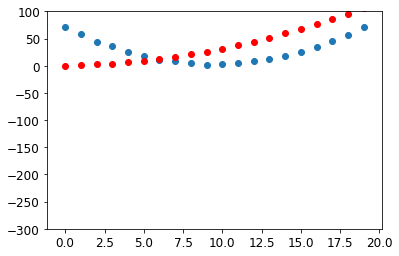

In [68]:
show_preds(preds)

A partir do gráfico, percebemos que nossas predições não estão muito perto dos valores medidos, ou seja, de nossos targets.

### 3- Calculando a loss

Em seguida, calculamos o valor da loss a partir da função de custo

In [69]:
loss = mse(preds, speed)
loss

tensor(1340.5829, grad_fn=<MeanBackward0>)

Nosso objetivo agora é melhorar isso. Para tanto, nós precisaremos conhecer os gradientes.

### 4- Calculando os gradientes

O próximo passo é calcular o gradiente, cujos valores indicam aproximadamente como os parâmetros devem mudar.

In [70]:
loss.backward()
params.grad

tensor([8669.1045,  560.3882,   19.8805])

## 5- Stepping

A partir disso, podemos definir uma taxa de aprendizagem a fim de atualizar os parâmetros. Nesse caso, a taxa será de 1e<sup>-5</sup> (0.00001). 

In [71]:
lr = 1e-5
params.data -= lr*params.grad.data
params.grad = None

Perceba que na última linha limpamos o gradiente para próximo _step_. 

Vamos verificar se nossos parâmetros atuais ajustaram a função melhor aos dados.

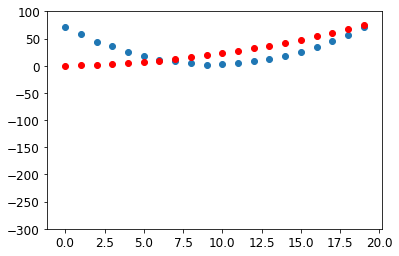

In [73]:
preds = f(time, params)
show_preds(preds)

Percebemos que a curva de ajuste está se aproximando dos dados medidos.

Como precisaremos repetir os procedimentos acima mais algumas vezes, vamos criar uma função para aplicar um _step_.

In [74]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr* params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds


### 6- Repita o processo

Agora, iteramos na expectativa de de alcançar bons resultados.

In [75]:
for i in range(10): apply_step(params)

799.0980224609375
696.6298217773438
677.2368774414062
673.5643310546875
672.8665771484375
672.7317504882812
672.703369140625
672.6951904296875
672.6907958984375
672.687255859375


Perceba que o valor da loss está decrescendo, como esperado. Em cada iteração, estamos tentando encontrar uma função quadrática que melhor ajuste os dados. Podemos visualizar esse processo a cada _step_ abaixo.

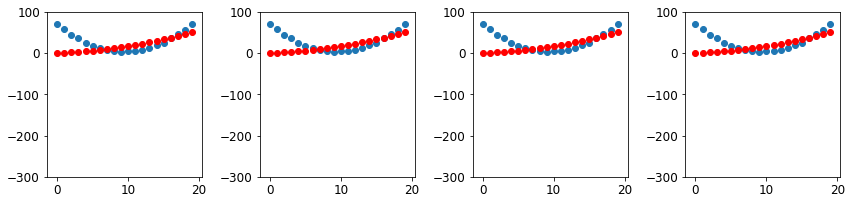

In [78]:
_, axs = plt.subplots(1,4, figsize= (12, 3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

### 7- Pare

Nós decidimos parar após 10 epochs arbitrariamente. Na prática, poderíamos assistir as losses do treinamento e da validação e outras métricas de modo a decidir quando parar.

## 6.4- Resumindo o gradiente descendente

No início, os valores dos parâmetros do nosso modelo podem ser aleatórios ou podem vir de outro modelo pré-treinado (_transfer learning_). Em ambos os casos, o modelo precisará aprender valores de parâmetros melhores.

Nesse contexto, inicialmente, comparamos os resultados do modelo (predições) com o que ele deveria retornar (targets) utilizando uma função de custo (_loss function_), que nos retorna uma número que desejamos tornar o menor possível ao melhorar os parâmetros. Para tanto, nós pegamos alguns itens (como imagens) do  nosso dataset de treinamento e alimentamos nosso modelo. Então, comparamos os resultados com os targets correspondentes utilizando a _loss function_. O valor que obtivermos nos diz quão erradas nossas predições estão. Para encontrar como alterar os parâmetros a fim de tornar a loss um pouco melhor, nós utilizamos o Cálculo para calcular os gradientes.

# 7- Loss function para o MNIST

Nós já temos nossas variáveis independentes, ou seja, as imagens. Precisamos apenas adaptá-las para o modelo que pretendemos desenvolver. Para tanto, iremos concatenar as imagens de ambos os dígitos em um único tensor, além de alterá-lo de uma lista de matrizes (rank 3) para uma lista de vetores (rank 2), por meio do método `view` que muda a dimensão do tensor sem alterar seu conteúdo. No nosso caso, repassaremos o argumento -1 para o método.

In [79]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

Em seguida, precisamos de uma _label_ para cada imagem. Nesse contexto, empregaremos 1 para os 3s e 0 para os 7s.

In [80]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

(torch.Size([12396, 784]), torch.Size([12396, 1]))

O método `unsqueeze` muda a dimensão do tensor. No caso, de [1, 12396] para [12396, 1].

Agora, precisamos concatenar as variáveis independentes com as a respectivas _labels_. Para tanto, empregaremos o função built-in do python `zip`.

In [82]:
dset = list(zip(train_x, train_y))
x, y = dset[1]
x.shape, y


(torch.Size([784]), tensor([1]))

Podemos empregar os mesmos procedimentos para construir o conjunto de validação.

In [85]:
valid_x = torch.cat([valid_3_tns, valid_7_tns]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tns)+[0]*len(valid_7_tns)).unsqueeze(1)
valid_dset = list(zip(valid_x, valid_y))

Agora, precisamso inicializar aleatoriamente os pesos para cada pixel. 

In [86]:
def init_params(size, std=1.): return (torch.randn(size)*std).requires_grad_()

In [89]:
weights = init_params((28*28, 1))

Porém, a função pesos x pixels não será suficientemente flexível, pois ela sempre será igual a zero quando os pixels são iguais a 0. Nesse contexto, você deve se lembrar que a fórmula de uma reta é y=w.x + b. Dessa forma, precisaremos incluir o termo b em nosso modelo. Vamos inicilizá-lo aleatoriamente também:

In [90]:
bias = init_params(1)

Em redes neurais, o termo w na equação é chamado de peso, enquanto que o b é chamado de viés. Juntos, pesos e vieses formam os parâmetros do modelo.

A partir disso, podemos calcular predições para uma imagem

In [91]:
(train_x[0]*weights.T).sum()+bias

tensor([-6.0525], grad_fn=<AddBackward0>)

Poderíamos empregar um laço for para calcular a predição para cada imagem, porém isso seria muito lento, pois os loops do Python não são executados na GPU, além de serem lentos quando comparados a outras linguagem. Nesse contexto, podemos aplicar simplesmente a multiplicação de matrizes. Em Python, tal operação é representa pelo operador @. 

In [93]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

tensor([[ -6.0525],
        [-10.4347],
        [ -3.7067],
        ...,
        [-14.2817],
        [  5.1424],
        [ -0.0173]], grad_fn=<AddBackward0>)

Perceba que o primeiro elemento é o mesmo que calculamos anteriormente, como esperado. A equação batch @ weights + bias é uma das duas mais fundamentais equações de qualquer rede neural. A outra é a _função de ativação_ que já iremos ver.

Agora, vamos verificar nossa acurácia. Para saber se uma saída do modelo representa um 3, podemos apenas verificar se ela é maior que 0, caso contrário, será um 7. Assim, podemos empregar o broadcasting.

In [95]:
corrects = (preds>0.0).float() == train_y
corrects

tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [False],
        [ True]])

In [96]:
corrects.float().mean().item()

0.3098580241203308